# Stacking model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
import pickle
import os
from datetime import datetime, timedelta
import warnings
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')

### Load and prepare data

In [2]:
# [Data loading and preprocessing remain unchanged]
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")

# Create time features
df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter

# Drop the original date column
df.drop(columns=['Posted Time'], inplace=True)

In [3]:
# Prepare target and features
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (18646, 37), X_test: (4662, 37)


### TRAIN INDIVIDUAL MODELS

In [4]:
# 1. Linear Regression
print("Training Linear Regression...")
linear_model = LinearRegression(
    fit_intercept=True,
    positive=False
)
linear_model.fit(X_train, y_train)

# 2. Ridge Regression
print("Training Ridge Regression...")
ridge_model = Ridge(
    alpha=0.01,
    solver='auto',
    random_state=42
)
ridge_model.fit(X_train, y_train)

# 3. XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=350,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# 4. LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    num_leaves=78,
    learning_rate=0.04,
    n_estimators=270,
    min_child_samples=24,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train)

Training Linear Regression...
Training Ridge Regression...
Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 18646, number of used features: 33
[LightGBM] [Info] Start training from score 7.076866


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.04, min_child_samples=24,
              n_estimators=270, n_jobs=-1, num_leaves=78, random_state=42,
              subsample=0.8)

### CREATE STACKING MODEL

In [5]:
# Define base models (Random Forest removed)
base_models = [
    ('linear', LinearRegression(
        fit_intercept=True,
        positive=False
    )),
    ('ridge', Ridge(
        alpha=0.01,
        solver='auto',
        random_state=42
    )),
    ('xgb', xgb.XGBRegressor(
        n_estimators=350,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
    ('lgb', lgb.LGBMRegressor(
        num_leaves=78,
        learning_rate=0.04,
        n_estimators=270,
        min_child_samples=24,
        subsample=0.8,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    ))
]

# Create stacking regressor with Linear Regression as meta-learner
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(
        fit_intercept=True,
        positive=False
    ),
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)

# Train stacking model
print("Training Stacking Model...")
stacking_model.fit(X_train, y_train)

Training Stacking Model...


StackingRegressor(cv=5,
                  estimators=[('linear', LinearRegression()),
                              ('ridge', Ridge(alpha=0.01, random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_wei...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=350, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgb',
                               LGBMRegressor(colsample_bytree=0.9,
                                             learning_rate=0.04,
                                             min_child_samples=24,
                                             n_estimators=270, n_jobs=-1,
                                             num_leaves=78, random_state=42,
                                             subsample=0.8))],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=1)

### EVALUATE ALL MODELS


MODEL EVALUATION

=== Linear Regression Results ===
Training - MSE: 1.38370, RMSE: 1.17631, MAE: 0.86561, R2: 0.59298
Test - MSE: 1.43403, RMSE: 1.19751, MAE: 0.86929, R2: 0.58645
CV R2 Score: 0.59123 (+/- 0.01661)

=== Ridge Regression Results ===
Training - MSE: 1.40334, RMSE: 1.18462, MAE: 0.86891, R2: 0.58720
Test - MSE: 1.45621, RMSE: 1.20674, MAE: 0.87192, R2: 0.58006
CV R2 Score: 0.58304 (+/- 0.01592)

=== XGBoost Results ===
Training - MSE: 0.27453, RMSE: 0.52395, MAE: 0.36237, R2: 0.91925
Test - MSE: 0.55508, RMSE: 0.74504, MAE: 0.49627, R2: 0.83993
CV R2 Score: 0.83559 (+/- 0.01584)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 1

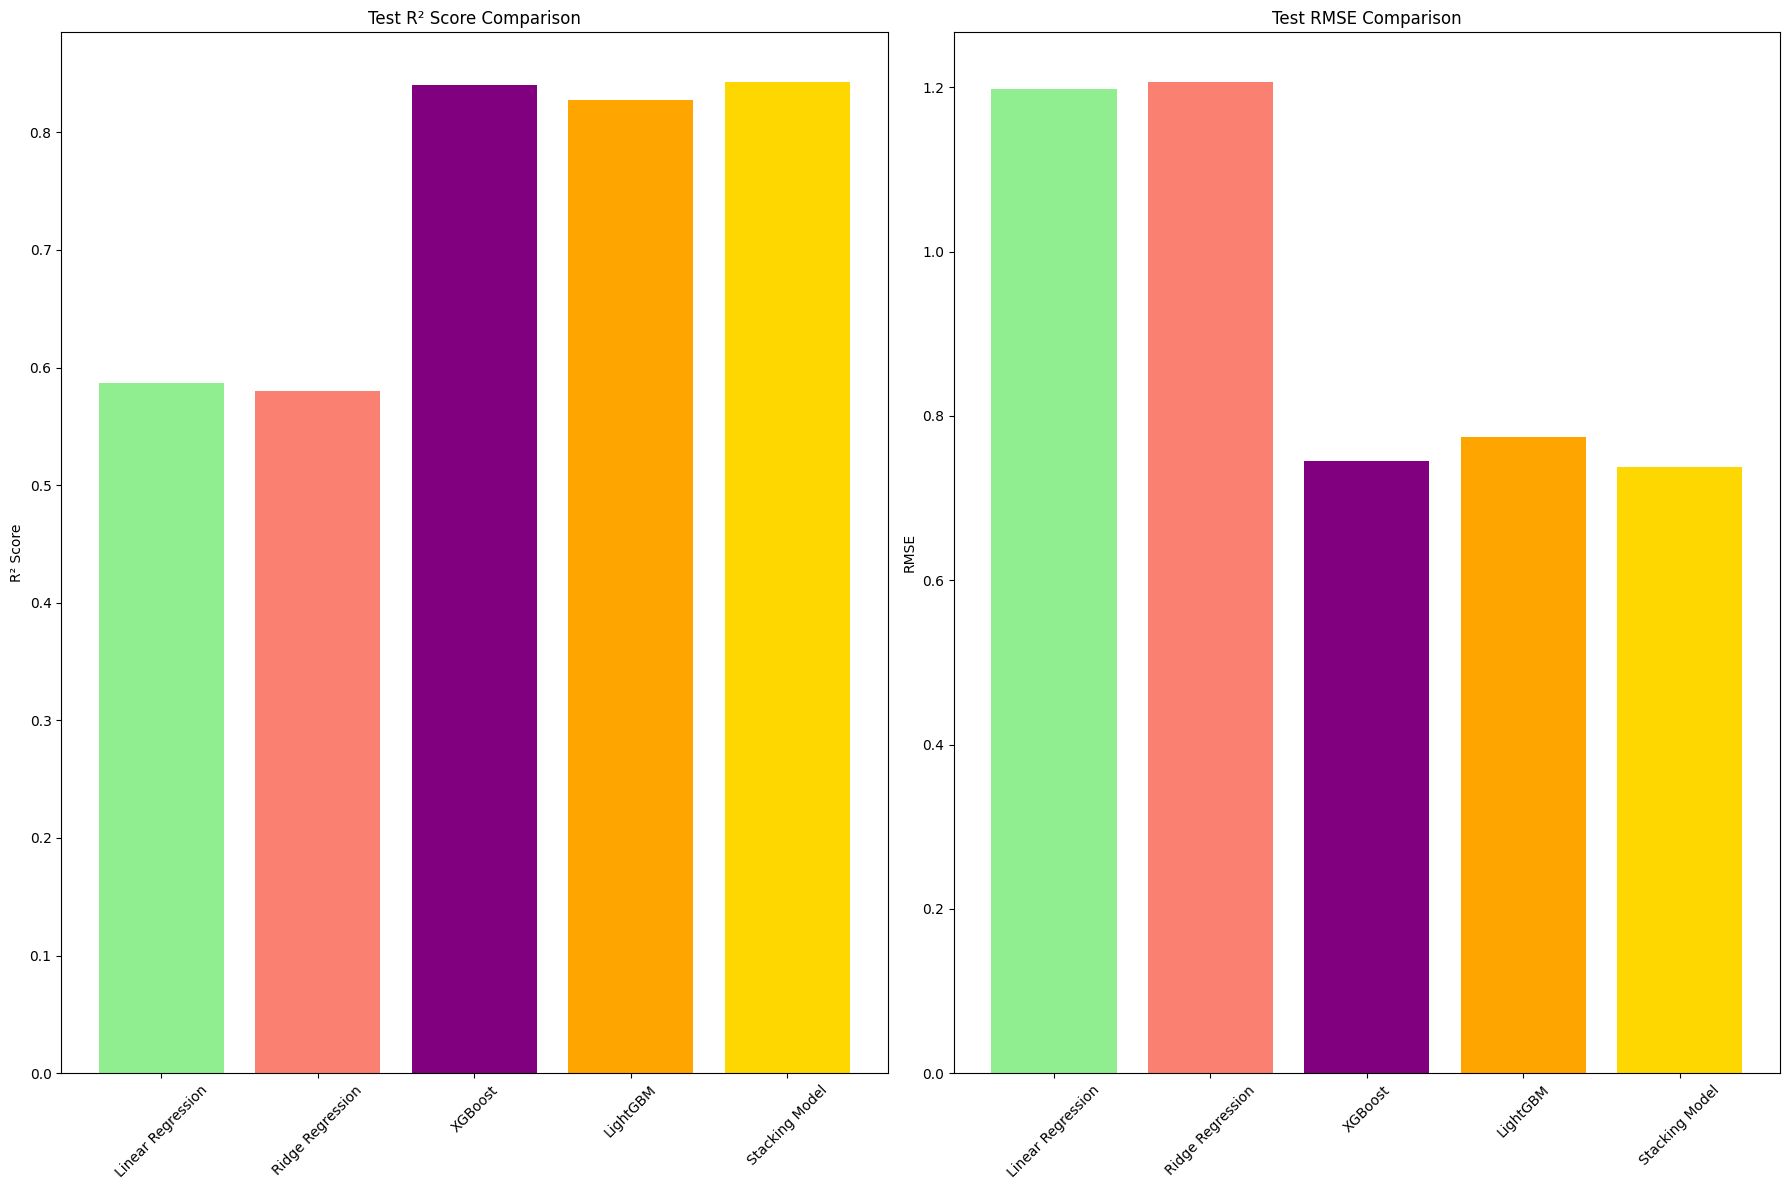

In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance"""
    
    # Training predictions
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    print(f"\n=== {model_name} Results ===")
    print(f"Training - MSE: {train_mse:.5f}, RMSE: {train_rmse:.5f}, MAE: {train_mae:.5f}, R2: {train_r2:.5f}")
    print(f"Test - MSE: {test_mse:.5f}, RMSE: {test_rmse:.5f}, MAE: {test_mae:.5f}, R2: {test_r2:.5f}")
    print(f"CV R2 Score: {cv_scores.mean():.5f} (+/- {cv_scores.std() * 2:.5f})")
    
    return {
        'model_name': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'cv_r2': cv_scores.mean(),
        'y_test_pred': y_test_pred
    }

# Evaluate all models
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

results = []
results.append(evaluate_model(linear_model, X_train, X_test, y_train, y_test, "Linear Regression"))
results.append(evaluate_model(ridge_model, X_train, X_test, y_train, y_test, "Ridge Regression"))
results.append(evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost"))
results.append(evaluate_model(lgb_model, X_train, X_test, y_train, y_test, "LightGBM"))
results.append(evaluate_model(stacking_model, X_train, X_test, y_train, y_test, "Stacking Model"))

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df[['model_name', 'train_r2', 'test_r2', 'test_rmse', 'test_mae', 'cv_r2']]

print("\n=== Model Comparison Summary ===")
print(comparison_df.round(5))

# Plotting comparisons
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# R2 Score Comparison
axes[0].bar(comparison_df['model_name'], comparison_df['test_r2'], 
              color=['lightgreen', 'salmon', 'purple', 'orange', 'gold'])
axes[0].set_title('Test R² Score Comparison')
axes[0].set_ylabel('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# RMSE Comparison
axes[1].bar(comparison_df['model_name'], comparison_df['test_rmse'], 
              color=['lightgreen', 'salmon', 'purple', 'orange', 'gold'])
axes[1].set_title('Test RMSE Comparison')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

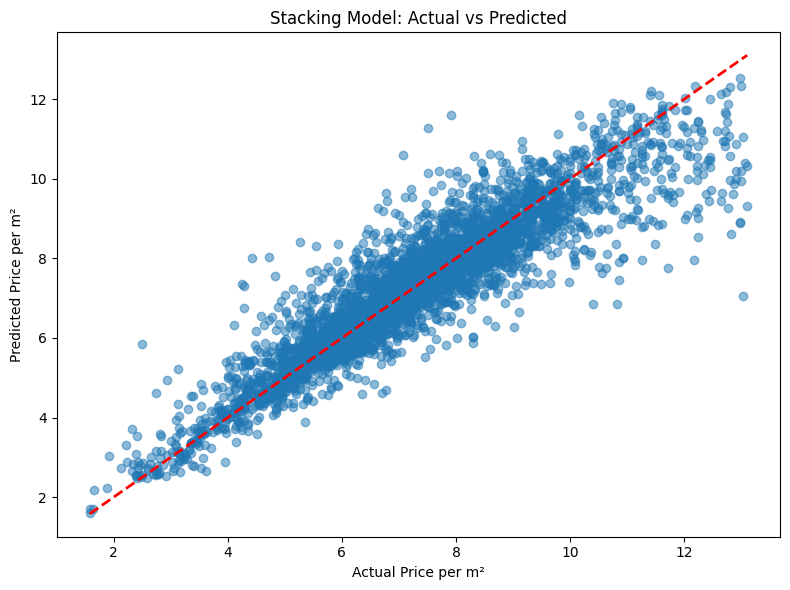

In [7]:
# Error distribution for stacking model
stacking_pred = stacking_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, stacking_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price per m²')
plt.ylabel('Predicted Price per m²')
plt.title('Stacking Model: Actual vs Predicted')
plt.tight_layout()
plt.show()


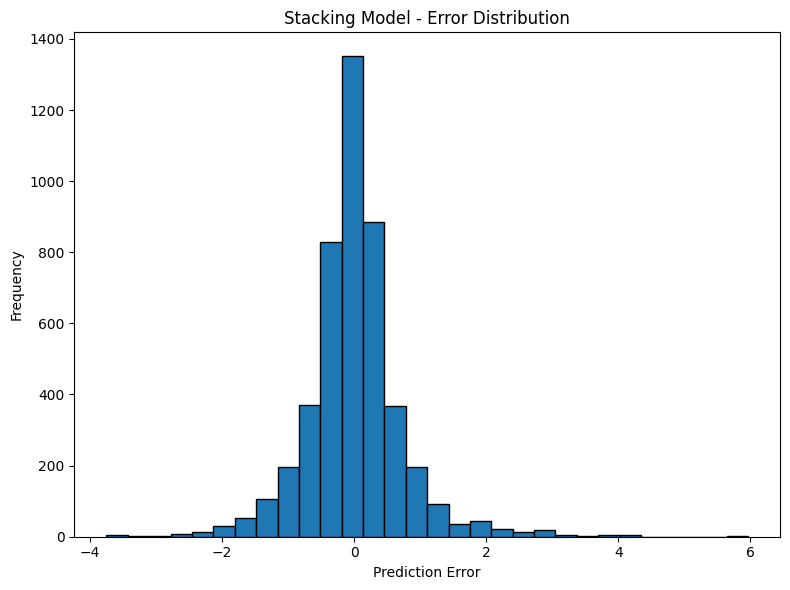

In [8]:
# Error distribution for stacking model
stacking_pred = stacking_model.predict(X_test)
errors = y_test - stacking_pred

plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Stacking Model - Error Distribution")
plt.tight_layout()
plt.show()
plt.close()

### FEATURE IMPORTANCE (for XGBoost and LightGBM in Stacking)

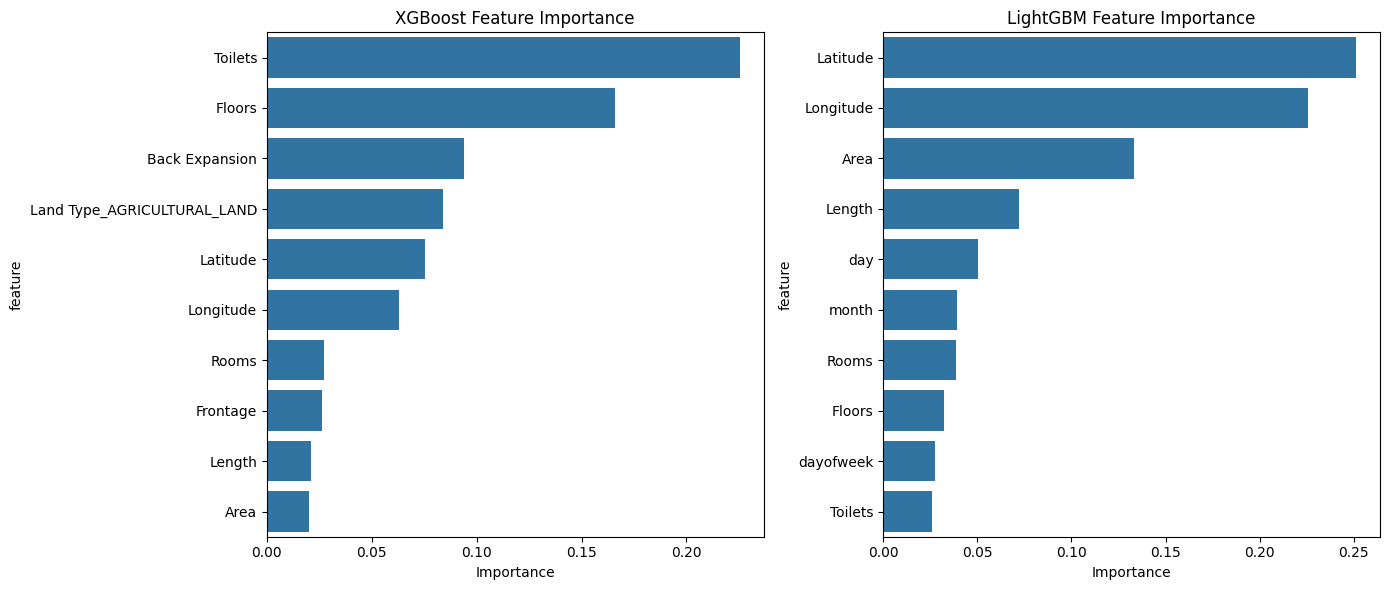


=== Top 10 Most Important Features ===

XGBoost:
                        feature  importance
7                       Toilets    0.225454
5                        Floors    0.165759
10               Back Expansion    0.094199
28  Land Type_AGRICULTURAL_LAND    0.083764
1                      Latitude    0.075335
0                     Longitude    0.062880
6                         Rooms    0.027461
12                     Frontage    0.026352
4                        Length    0.021154
2                          Area    0.020098

LightGBM:
      feature  importance
1    Latitude    0.251371
0   Longitude    0.225541
2        Area    0.133478
4      Length    0.072102
34        day    0.050409
33      month    0.039250
6       Rooms    0.038769
5      Floors    0.032371
35  dayofweek    0.027609
7     Toilets    0.026070


In [9]:
# Plot feature importance for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Reduced to 2 subplots

# XGBoost
xgb_base_model = stacking_model.named_estimators_['xgb']
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_base_model.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(data=xgb_importance.head(10), x='importance', y='feature', ax=axes[0])
axes[0].set_title('XGBoost Feature Importance')
axes[0].set_xlabel('Importance')

# LightGBM
lgb_base_model = stacking_model.named_estimators_['lgb']
lgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_base_model.feature_importances_ / np.sum(lgb_base_model.feature_importances_)
}).sort_values('importance', ascending=False)
sns.barplot(data=lgb_importance.head(10), x='importance', y='feature', ax=axes[1])
axes[1].set_title('LightGBM Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

print("\n=== Top 10 Most Important Features ===")
print("\nXGBoost:")
print(xgb_importance.head(10))
print("\nLightGBM:")
print(lgb_importance.head(10))

### SAVE STACKING MODEL

In [10]:
output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)

# Retrain stacking model on the full dataset
print("Retraining Stacking Model on full dataset...")
stacking_model_full = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(
        fit_intercept=True,
        positive=False
    ),
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)
stacking_model_full.fit(X, y)  # Train on full dataset X and y

# Save stacking model as pickle file
filename = 'forecast_model.pkl'
filepath = os.path.join(output_dir, filename)
with open(filepath, 'wb') as f:
    pickle.dump(stacking_model_full, f)  # Save the model trained on full dataset
print(f"Saved: {filepath}")

# Save stacking model as PMML
try:
    stacking_pipeline = PMMLPipeline([("regressor", stacking_model_full)])
    pmml_filename = 'forecast_model.pmml'
    pmml_filepath = os.path.join(output_dir, pmml_filename)
    sklearn2pmml(stacking_pipeline, pmml_filepath)
    print(f"Saved PMML: {pmml_filepath}")
except Exception as e:
    print(f"Warning: Could not save PMML file: {e}")
    print("PMML files may not be supported for Stacking models with XGBoost and LightGBM")

Retraining Stacking Model on full dataset...
Saved: ../../Backend/src/main/resources/forecast_model.pkl
Saved PMML: ../../Backend/src/main/resources/forecast_model.pmml


### MODEL PERFORMANCE SUMMARY

In [11]:
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

best_model_idx = comparison_df['test_r2'].idxmax()
best_model = comparison_df.iloc[best_model_idx]

print(f"Best Model: {best_model['model_name']}")
print(f"Test R² Score: {best_model['test_r2']:.5f}")
print(f"Test RMSE: {best_model['test_rmse']:.5f}")
print(f"Cross-Validation R²: {best_model['cv_r2']:.5f}")

# Performance improvement over XGBoost (since Random Forest is removed)
xgb_r2 = comparison_df[comparison_df['model_name'] == 'XGBoost']['test_r2'].iloc[0]
improvement = ((best_model['test_r2'] - xgb_r2) / xgb_r2) * 100
print(f"Improvement over XGBoost: {improvement:.2f}%")

print("\n=== Stacking Model Saved Successfully! ===")
print("Files saved:")
print("- Stacking model pickle file (trained on full dataset)")
print("- PMML file (if supported)")
print(f"- Output directory: {output_dir}")


FINAL MODEL PERFORMANCE SUMMARY
Best Model: Stacking Model
Test R² Score: 0.84285
Test RMSE: 0.73819
Cross-Validation R²: 0.83786
Improvement over XGBoost: 0.35%

=== Stacking Model Saved Successfully! ===
Files saved:
- Stacking model pickle file (trained on full dataset)
- PMML file (if supported)
- Output directory: ../../Backend/src/main/resources/


### PREDICTION EXAMPLE

In [12]:
print("\n=== Prediction Example ===")
if len(X_test) > 0:
    sample_idx = 0
    sample_input = X_test.iloc[sample_idx:sample_idx+1]
    actual_price = y_test.iloc[sample_idx]
    
    print(f"Sample input features: {sample_input.values[0][:5]}...")  # Show first 5 features
    print(f"Actual price per m²: {actual_price:.2f}")
    
    # Predictions from all models (Random Forest removed)
    linear_pred = linear_model.predict(sample_input)[0]
    ridge_pred = ridge_model.predict(sample_input)[0]
    xgb_pred = xgb_model.predict(sample_input)[0]
    lgb_pred = lgb_model.predict(sample_input)[0]
    stacking_pred = stacking_model.predict(sample_input)[0]  # Using original stacking model for example
    
    print(f"Linear Regression prediction: {linear_pred:.2f}")
    print(f"Ridge Regression prediction: {ridge_pred:.2f}")
    print(f"XGBoost prediction: {xgb_pred:.2f}")
    print(f"LightGBM prediction: {lgb_pred:.2f}")
    print(f"Stacking Model prediction (original): {stacking_pred:.2f}")
    
    # Prediction using the model trained on full dataset
    stacking_full_pred = stacking_model_full.predict(sample_input)[0]
    print(f"Stacking Model prediction (full dataset): {stacking_full_pred:.2f}")
    
    print(f"Stacking model error (original): {abs(stacking_pred - actual_price):.2f}")
    print(f"Stacking model error (full dataset): {abs(stacking_full_pred - actual_price):.2f}")


=== Prediction Example ===
Sample input features: [10.40248576  3.99832853 10.          2.23606798  4.47213595]...
Actual price per m²: 5.65
Linear Regression prediction: 5.51
Ridge Regression prediction: 5.59
XGBoost prediction: 5.77
LightGBM prediction: 5.66
Stacking Model prediction (original): 5.76
Stacking Model prediction (full dataset): 5.57
Stacking model error (original): 0.11
Stacking model error (full dataset): 0.08


### 90-DAY FORECAST


=== Generating 90-day Forecast ===


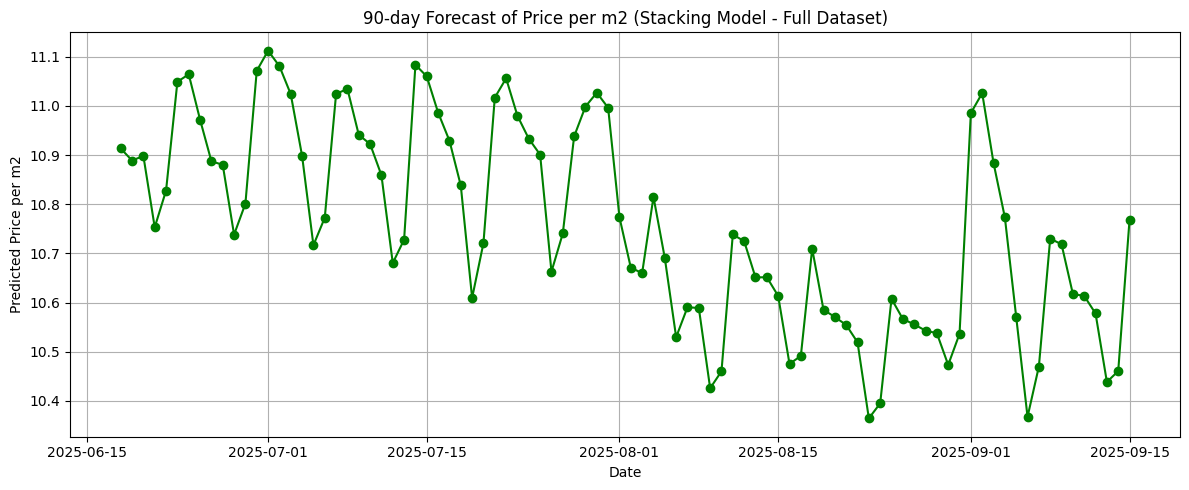

Forecast shows a downward trend (average daily change: -0.00162)


In [13]:
print("\n=== Generating 90-day Forecast ===")

# Get baseline (latest sample)
base = X.iloc[-1].copy()

# Start date for forecasting (today)
start_date = pd.Timestamp.now().normalize()

# Generate forecasts using the model trained on full dataset
results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Update time features
    f['year'] = date.year
    f['month'] = date.month
    f['day'] = date.day
    f['dayofweek'] = date.weekday()
    f['quarter'] = date.quarter
    
    # Predict
    X_pred = f.to_frame().T  # Convert Series to DataFrame
    pred_price = stacking_model_full.predict(X_pred)[0]  # Use model trained on full dataset
    
    results.append({
        'Date': date,
        'Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], marker='o', color='green')
plt.title('90-day Forecast of Price per m2 (Stacking Model - Full Dataset)')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Check for upward trend
trend = forecast_df['Predicted_Price_per_m2'].diff().mean()
if trend > 0:
    print("Forecast shows an upward trend (average daily change: {:.5f})".format(trend))
elif trend < 0:
    print("Forecast shows a downward trend (average daily change: {:.5f})".format(trend))
else:
    print("Forecast shows no clear trend (average daily change: 0)")